In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
import nltk
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding

In [0]:
# Load the data
data = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
test_predection = pd.read_csv('test_data_hidden.csv')

In [163]:
data.head(5)

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive


In [0]:
Positive = data[data['sentiment']== "Positive"].iloc[:,[5,6,7]]
Neutral = data[data['sentiment']== "Neutral"].iloc[:,[5,6,7]]
Negative = data[data['sentiment']== "Negative"].iloc[:,[5,6,7]]

In [165]:
Positive['sentiment'].value_counts()

Positive    3749
Name: sentiment, dtype: int64

In [166]:
Neutral['sentiment'].value_counts()

Neutral    158
Name: sentiment, dtype: int64

In [167]:
Negative['sentiment'].value_counts()

Negative    93
Name: sentiment, dtype: int64

In [0]:
# 2.Convert the reviews in Tf-Idf score.

In [0]:
# Keeping only those features that we will explore
data1 = data [["sentiment","reviews.text"]]

In [170]:
data1.head()

,sentiment,reviews.text
0,Positive,Purchased on Black FridayPros - Great Price (e...
1,Positive,I purchased two Amazon in Echo Plus and two do...
2,Neutral,Just an average Alexa option. Does show a few ...
3,Positive,"very good product. Exactly what I wanted, and ..."
4,Positive,This is the 3rd one I've purchased. I've bough...


In [0]:
# Resetting the index
data1.index = pd.Series(list(range(data1.shape[0])))

In [172]:
print('Shape : ',data1.shape)
data1.head()

Shape :  (4000, 2)


,sentiment,reviews.text
0,Positive,Purchased on Black FridayPros - Great Price (e...
1,Positive,I purchased two Amazon in Echo Plus and two do...
2,Neutral,Just an average Alexa option. Does show a few ...
3,Positive,"very good product. Exactly what I wanted, and ..."
4,Positive,This is the 3rd one I've purchased. I've bough...


##Creating Preprocessing Function and Applying it on Our Data

In [173]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
#Download Stopwords
nltk.download('stopwords')

wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')
stop_words = set(stopwords.words('english'))

def preprocess(document):
    document = document.lower() # Convert to lowercase
    words = tokenizer.tokenize(document) # Tokenize
    words = [w for w in words if not w in stop_words] # Removing stopwords
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    return " ".join(words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [174]:
data1['Processed_Review'] = data1['reviews.text'].apply(preprocess)

data1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,sentiment,reviews.text,Processed_Review
0,Positive,Purchased on Black FridayPros - Great Price (e...,purchase black fridaypros great price even sal...
1,Positive,I purchased two Amazon in Echo Plus and two do...,purchase two amazon echo plus two dot plus fou...
2,Neutral,Just an average Alexa option. Does show a few ...,average alexa option show thing screen still l...
3,Positive,"very good product. Exactly what I wanted, and ...",good product exactly want good price
4,Positive,This is the 3rd one I've purchased. I've bough...,rd one purchase buy one niece case compare one...


In [175]:
data2 = data1 [["sentiment","Processed_Review"]]
data2.head()

,sentiment,Processed_Review
0,Positive,purchase black fridaypros great price even sal...
1,Positive,purchase two amazon echo plus two dot plus fou...
2,Neutral,average alexa option show thing screen still l...
3,Positive,good product exactly want good price
4,Positive,rd one purchase buy one niece case compare one...


In [0]:
# Creating TF-IDF Matrix & multinomial Naive Bayes classifier

In [0]:
def textPreprocessing(data2):
    #Remove Punctuation Logic
    import string
    removePunctuation = [char for char in data2 if char not in string.punctuation]
    #Join Chars to form sentences
    sentenceWithoutPunctuations = ''.join(removePunctuation)
    words = sentenceWithoutPunctuations.split()
    #StopwordRemoval
    from nltk.corpus import stopwords
    removeStopwords = [word for word in words if word.lower() not in stopwords.words('english')]
    
    return removeStopwords

In [178]:
data2.groupby('sentiment').describe()

Processed_Review  ...     
                     count  ... freq
sentiment                   ...     
Negative                93  ...    3
Neutral                158  ...    2
Positive              3749  ...    4

[3 rows x 4 columns]

In [179]:
#Text preprocessing
data2['Processed_Review'].head(2).apply(textPreprocessing)

0    [purchase, black, fridaypros, great, price, ev...
1    [purchase, two, amazon, echo, plus, two, dot, ...
Name: Processed_Review, dtype: object

In [0]:
#My intention is to create Bag of Words
#sklearn package CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(analyzer=textPreprocessing).fit(data2['Processed_Review'])

In [0]:
#bow.vocabulary_

In [182]:
len(bow.vocabulary_)

3407

In [0]:
reviews_bow = bow.transform(data2['Processed_Review'])

In [0]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidfData = TfidfTransformer().fit(reviews_bow)
tfidfDataFinal = tfidfData.transform(reviews_bow)

In [185]:
tfidfDataFinal.shape 

(4000, 3407)

In [0]:
# The data is reddy for model building

In [0]:
#Training the model --- NaiveBayes Algo
#Handling String data ---- MultinomialNB
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(tfidfDataFinal,data2['sentiment'])

In [188]:
model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [189]:
inputData = 'dont like very bad'
l1 = textPreprocessing(inputData)
l2 = bow.transform(l1)
l3 = tfidfData.transform(l2)
prediction = model.predict(l3[0])
prediction

array(['Positive'], dtype='<U8')

# Week 2

In [0]:
#Tackling Class Imbalance Problem:

In [191]:
#Create independent and Dependent Features
columns = data2.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["sentiment"]]
# Store the variable we are predicting 
target = "sentiment"
# Define a random state 
state = np.random.RandomState(42)
X = data2[columns]
Y = data2[target]
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(4000, 1)
(4000,)


In [192]:
print(data2.sentiment.value_counts())

Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64


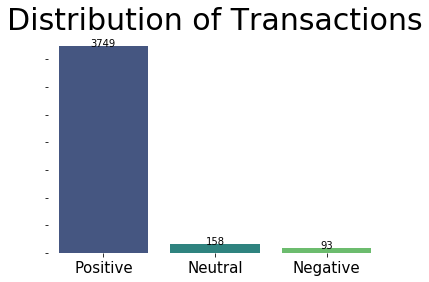

In [193]:

# using seaborns countplot to show distribution of questions in dataset
fig, ax = plt.subplots()
g = sns.countplot(data1.sentiment, palette='viridis')
g.set_xticklabels(['Positive', 'Neutral','Negative'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Transactions', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [194]:
print(Positive.shape,Neutral.shape,Negative.shape)

(3749, 3) (158, 3) (93, 3)


In [0]:
## Applying Over Sampling

In [196]:
## RandomOverSampler to handle imbalanced data
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0) 
X_res,Y_res=ros.fit_sample(X,Y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [197]:
from collections import Counter
print(sorted(Counter(Y_res).items()))

[('Negative', 3749), ('Neutral', 3749), ('Positive', 3749)]


In [198]:
X_res.shape,Y_res.shape

((11247, 1), (11247,))

In [199]:
#Checking out old and new data
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(Y_res)))

Original dataset shape Counter({'Positive': 3749, 'Neutral': 158, 'Negative': 93})
Resampled dataset shape Counter({'Positive': 3749, 'Neutral': 3749, 'Negative': 3749})


In [0]:
#Creating X output to dataframe
X1=pd.DataFrame(X_res,columns=['Processed_Review'])

In [0]:
#creating Y output to dataframe cor merge
Y1=pd.DataFrame(Y_res,columns=['sentiment'])

In [202]:
#merge the X & Y output to final data
Final_data=pd.concat([X1,Y1],axis=1)
Final_data.head()

,Processed_Review,sentiment
0,purchase black fridaypros great price even sal...,Positive
1,purchase two amazon echo plus two dot plus fou...,Positive
2,average alexa option show thing screen still l...,Neutral
3,good product exactly want good price,Positive
4,rd one purchase buy one niece case compare one...,Positive


In [203]:
Final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11247 entries, 0 to 11246
Data columns (total 2 columns):
Processed_Review    11247 non-null object
sentiment           11247 non-null object
dtypes: object(2)
memory usage: 175.9+ KB


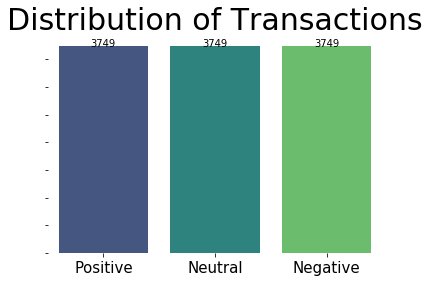

In [204]:

# plot the final data using seaborns countplot to show distribution of sentiment in dataset
fig, ax = plt.subplots()
g = sns.countplot(Final_data.sentiment, palette='viridis')
g.set_xticklabels(['Positive', 'Neutral','Negative'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Transactions', fontsize=30)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

In [205]:
df = Final_data.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
#df['Sentiment'] = np.where(df['Sentiment'] > 3, 1, 0)
df.head()

,Processed_Review,sentiment
8805,buy think would great read book play game howe...,Neutral
9736,good tablet kid lot appts download game,Neutral
125,item work expect great product,Positive
10143,great beginner like child limit use many apps ...,Neutral
10937,buy kindle past time one come defective port b...,Neutral


In [0]:
# Convert the sentiments
# Positive=1,Negative=0,Neutral=2
#df.sentiment.replace(('Positive','Negative','Neutral'),(1,0,2),inplace=True)

# Train and Test Split data

In [207]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Review'], df['sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 1012 training examples and 113 validation examples. 

Show a review in the training set : 
 daughter love easy navigate hard break


#Bag of Words

The goal of this project is to classify the reviews into positive and negative sentiment. There are two main steps involved. First, we need to find a word embedding to convert a text into a numerical representation. Second, we fit the numerical representations of text to machine learning algorithms or deep learning architectures.

One common approach of word embedding is frequency based embedding such as Bag of Words (BoW) model. BoW model learns a vocubulary list from a given corpus and represents each document based on some counting methods of words. In this part, we will explore the model performance of using BoW with supervised learning algorithms. Here's the workflow in this part.

* Step 1 : Preprocess raw reviews to cleaned reviews
* Step 2 : Create BoW using CountVectorizer / Tfidfvectorizer in sklearn
* Step 3 : Transform review text to numerical representations (feature vectors)
* Step 4 : Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)
* Step 5 : Improve the model performance by GridSearch

#Text Preprocessing

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.
* remove html tags using BeautifulSoup
* remove non-character such as digits and symbols
* convert to lower case
* remove stop words such as "the" and "and" if needed
* convert to root words by stemming if needed

In [0]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [209]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

Show a cleaned review in the training set : 
 daughter love easy navigate hard break


#CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm.

In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. The output is a sparse matrix representation of a document.

In [210]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 1511 

Show some feature names : 
 ['ability', 'playtime']


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    #print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [212]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.8938

Classification report : 
               precision    recall  f1-score   support

    Negative       0.93      0.95      0.94        39
     Neutral       0.85      0.90      0.88        39
    Positive       0.91      0.83      0.87        35

    accuracy                           0.89       113
   macro avg       0.89      0.89      0.89       113
weighted avg       0.89      0.89      0.89       113


Confusion Matrix : 
 [[37  0  2]
 [ 3 35  1]
 [ 0  6 29]]


#TfidfVectorizer with Logistic Regression

Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus.

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [213]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 691 

Show some feature names : 
 ['able']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [214]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['love' 'easy' 'great' 'play' 'read' 'alexa' 'kid' 'price' 'well' 'enjoy']

Top 10 features with largest coefficients : 
['return' 'update' 'bad' 'know' 'terrible' 'th' 'poor' 'try' 'minute'
 'youtube']


In [215]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9292

Classification report : 
               precision    recall  f1-score   support

    Negative       0.93      1.00      0.96        39
     Neutral       0.88      0.92      0.90        39
    Positive       1.00      0.86      0.92        35

    accuracy                           0.93       113
   macro avg       0.94      0.93      0.93       113
weighted avg       0.93      0.93      0.93       113


Confusion Matrix : 
 [[39  0  0]
 [ 3 36  0]
 [ 0  5 30]]


#Pipeline and GridSearch

In sklearn library, we can build a pipeline to streamline the workflow and use GridSearch on the pipeline model to implement hyper-parameter tuning for both vectorizer and classifier in one go.

In [216]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

Accuracy on validation set: 0.9381

Classification report : 
               precision    recall  f1-score   support

    Negative       0.97      0.97      0.97        39
     Neutral       0.90      0.95      0.92        39
    Positive       0.94      0.89      0.91        35

    accuracy                           0.94       113
   macro avg       0.94      0.94      0.94       113
weighted avg       0.94      0.94      0.94       113


Confusion Matrix : 
 [[38  0  1]
 [ 1 37  1]
 [ 0  4 31]]


#Word2Vec

Another common approach of word embedding is prediction based embedding, such as Word2Vec model. In gist, Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and skip-gram model. Both are shallow neural networks which learn weights for word vector representations.

In this part, we will train Word2Vec model to create our own word vector representations using gensim library. Then we fit the feature vectors of the reviews to Random Forest Classifier. Here's the workflow of this part.

* Step 1 : Parse review text to sentences (Word2Vec model takes a list of sentences as inputs)
* Step 2 : Create volcabulary list using Word2Vec model
* Step 3 : Transform each review into numerical representation by computing average feature vectors of words therein
* Step 4 : Fit the average feature vectors to Random Forest Classifier

#Parsing Review into Sentences

Word2Vec model takes a list of sentences as inputs and outputs word vector representations for words in the vocalbulary list created. Before we train the Word2Vec model, we have to parse reviews in the training set into sentences.

In [217]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [218]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

1012 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['daughter', 'love', 'easy', 'navigate', 'hard', 'break']


#Creating Volcabulary List usinhg Word2Vec Model

Now we have a set of cleaned and parsed sentences from the training data, we can train our own word evctor representations by sepcifiying the embedding dimension (= length of feature vector).

In [219]:
# Fit parsed sentences to Word2Vec model 
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 416 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['buy', 'tablet', 'use', 'good', 'great', 'work', 'get', 'one', 'amazon', 'kindle']


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#Averaging Feature Vectors

Now we have created a volcabulary list of words, with each word having a word representation (ie. feature vector of dim 300).

To find a numerical representation for a review, we run through each word in a review text. For words appear in the volcabulary list, we compute the average feature vectors of all those words. The average feature vector is the numerical represenation of the review. 

In [0]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [221]:
# Get feature vectors for training set
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" %trainVector.shape)


# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True, split_text=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" %testVector.shape)


# debugging
# print("Checkinf for NaN and Inf")
# print("np.inf=", np.where(np.isnan(trainVector)))
# print("is.inf=", np.where(np.isinf(trainVector)))
# print("np.max=", np.max(abs(trainVector)))

Training set : 1012 feature vectors with 300 dimensions
Validation set : 113 feature vectors with 300 dimensions


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


#Random Forest Classifer

We can now train Random Forest Classifier using feature vectors of reviews in the training set. 

In [222]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.9646

Classification report : 
               precision    recall  f1-score   support

    Negative       1.00      0.97      0.99        39
     Neutral       0.95      0.97      0.96        39
    Positive       0.94      0.94      0.94        35

    accuracy                           0.96       113
   macro avg       0.96      0.96      0.96       113
weighted avg       0.97      0.96      0.96       113


Confusion Matrix : 
 [[38  0  1]
 [ 0 38  1]
 [ 0  2 33]]


# Apply LSTM

Long Short Term Memory networks (LSTM) are a special kind of Recurrent Neural Networks (RNN), capable of learning long-term dependencies. LSTM can be very usefull in text mining problems since it involves dependencies in the sentences which can be caught in the "memory" of the LSTM.

In this part, we train a simple LSTM and a LSTM with Word2Vec embedding to classify the reviews into positive and negative  sentiment using Keras libarary.

#Simple LSTM

We need to preprocess the text data to 2D tensor before we fit into a simple LSTM. First, we tokenize the corpus by only considering top words (top_words = 20000), and transform reviews to numerical sequences using the trained tokenizer. Next, we make sure that all numerical sequences have the same length (maxlen=100) for modeling, by truncating long reviews and pad shorter reviews with zero values.

To construct a simple LSTM, we use embedding class in Keras to construct the first layer. This embedding layer converts numerical sequence of words into a word embedding. We should note that the embedding class provides a convenient way to map discrete words into a continuous vector space, but it does not take the semantic similarity of the words into account. The next layer is the LSTM layer with 128 memory units. Finally, we use a dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (positive sentiment and negative sentiment). Since it is a binary classification problem, log loss is used as the loss function (binary_crossentropy in Keras). ADAM optimization algorithm is used.

Here's the workflow in this part.
* Step 1 : Prepare X_train and X_test to 2D tensor
* Step 2 : Train a simple LSTM (embeddign layer => LSTM layer => dense layer)
* Step 3 : Compile and fit the model using log loss function and ADAM optimizer

In [0]:
df = Final_data.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df.head()

# Convert the sentiments
# Positive=1,Negative=0,Neutral=2
df.sentiment.replace(('Positive','Negative','Neutral'),(1,0,2),inplace=True)

In [0]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Processed_Review'], df['sentiment'], \
                                                    test_size=0.1, random_state=1)

In [0]:
#df.sentiment.replace(('Positive','Negative','Neutral'),(1,0,2),inplace=True)

In [232]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 3
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (1012, 100)
X_test shape: (113, 100)
y_train shape: (1012, 3)
y_test shape: (113, 3)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [233]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128, dropout=0.2))
model1.add(LSTM(128, dropout_W=0.2, dropout_U=0.2)) 
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

# Model evluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 2,691,971
Trainable params: 2,691,971
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]





Epoch 1/3





1012/1012 [==============================] - 8s 8ms/step - loss: 0.6179 - acc: 0.6673
Epoch 2/3
1012/1012 [==============================] - 7s 7ms/step - loss: 0.4082 - acc: 0.8109
Epoch 3/3
113/113 [==============================] - 0s 3ms/step
Test loss : 0.2240
Test accuracy : 0.8938


In [234]:
# get weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (20000, 128)
Size of weight matrix in the hidden layer :  (128, 512)
Size of weight matrix in the output layer :  (128, 3)


#LSTM with Word2Vec Embedding

In the simple LSTM model constructed above, the embedding class in Keras comes in handy to converts numerical sequence of words into a word embedding, but it does not take the semantic similarity of the words into account.  The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.

Instead of using random weights, we can use pretrained word embeddings to initialize the weight of an embedding layer. In this part, we use the Word2Vec embedding trained in Part 4 to 
intialize the weights of embedding layer in LSTM.

* Step 1 : Load pretrained word embedding model
* Step 2 : Construct embedding layer using embedding matrix as weights
* Step 3 : Train a LSTM with Word2Vec embedding (embeddign layer => LSTM layer => dense layer)
* Step 4 : Compile and fit the model using log loss function and ADAM optimizer

In [235]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.syn0  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

Shape of embedding matrix :  (416, 300)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """


In [236]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 3
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = np_utils.to_categorical(y_train, nb_classes)
y_test_seq = np_utils.to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (1012, 100)
X_test shape: (113, 100)
y_train shape: (1012, 3)
y_test shape: (113, 3)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [237]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix])


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128, dropout_W=0.2, dropout_U=0.2)) 
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`
  if __name__ == '__main__':


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         124800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 344,835
Trainable params: 344,835
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/3
1012/1012 [==============================] - 9s 9ms/step - loss: 0.6253 - acc: 0.6667
Epoch 2/3
1012/1012 [==============================] - 8s 7ms/step - loss: 0.4611 - acc: 0.7800
Epoch 3/3
113/113 [==============================] - 0s 4ms/step
Test loss : 0.2882
Test accuracy : 0.8525


In [238]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (416, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 3)
